# Training a RNN model using the basic negation data (version 1)


## Here we will use the RNN model to distinguish between to kind of sentences:

- A, not A (**contradiction**)

- A, not B (**non contradiction**)


In [1]:
# all imports
import numpy as np
import pandas as pd
import torch
from torchtext import data
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

import os
import inspect
import sys
import itertools

almost_current = os.path.abspath(inspect.getfile(inspect.currentframe()))
currentdir = os.path.dirname(almost_current)
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from plots.functions  import plot_confusion_matrix, plot_histogram_from_labels
from text_processing.functions import simple_pre_process_text_df, simple_pre_process_text

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_v1_train.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_v1_test.csv")

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [3]:
train_data.head()

,sentence1,sentence2,label
0,Winston is lively,Brooklyn is not nice,0
1,Reynold is witty,Quanda is not thankful,0
2,Hazel is brave,Charity is not witty,0
3,Sutcliff is silly,Lyle is not ambitious,0
4,Banner is ambitious,Banner is not ambitious,1


In [4]:
test_data.head()

,sentence1,sentence2,label
0,Radella is jolly,Radella is not jolly,1
1,Harris is proud,Westcott is not ambitious,0
2,Ellery is obedient,Josie is not delightful,0
3,Win is brave,Esmond is not eager,0
4,Everly is eager,Osborn is not happy,0


## Putting the sentences together

In [5]:
train_data["text"] = train_data["sentence1"]  + ", " + train_data["sentence2"]
test_data["text"] = test_data["sentence1"]  + ", " + test_data["sentence2"]
train_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
test_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
train_data = train_data[["text", "label"]]
test_data = test_data[["text", "label"]] 

In [6]:
train_data.head()

,text,label
0,"Winston is lively, Brooklyn is not nice",0
1,"Reynold is witty, Quanda is not thankful",0
2,"Hazel is brave, Charity is not witty",0
3,"Sutcliff is silly, Lyle is not ambitious",0
4,"Banner is ambitious, Banner is not ambitious",1


In [7]:
test_data.head()

,text,label
0,"Radella is jolly, Radella is not jolly",1
1,"Harris is proud, Westcott is not ambitious",0
2,"Ellery is obedient, Josie is not delightful",0
3,"Win is brave, Esmond is not eager",0
4,"Everly is eager, Osborn is not happy",0


In [8]:
labels_legend = ['no', 'yes']
anwser2int = {'no':0, 'yes':1}
int2anwser = {i[1]: i[0] for i in anwser2int.items()}
train_labels = [int2anwser[i] for i in train_data["label"].values]
test_labels = [int2anwser[i] for i in train_data["label"].values]

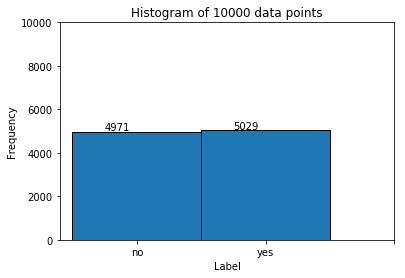

In [9]:
plot_histogram_from_labels(train_labels, labels_legend, "train data")

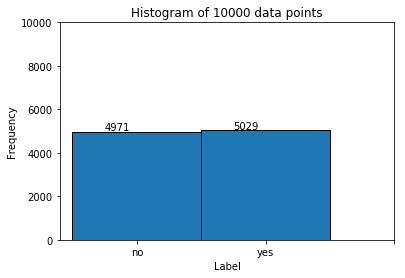

In [10]:
plot_histogram_from_labels(test_labels, labels_legend, "train data")

### Applying preprocessing function

In [11]:
print("\n=== BEFORE ===\n")

print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


print("\n=== AFTER ===\n")
simple_pre_process_text_df(train_data)
simple_pre_process_text_df(test_data)
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


=== BEFORE ===

Hazel is brave, Charity is not witty

Sutcliff is silly, Lyle is not ambitious

Banner is ambitious, Banner is not ambitious

=== AFTER ===

hazel is brave charity is not witty

sutcliff is silly lyle is not ambitious

banner is ambitious banner is not ambitious


## Saving the new version of the data in a csv

In [12]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_v1_train_processed.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_v1_test_processed.csv")


train_data.to_csv(train_data_path, header=False, index=False)
test_data.to_csv(test_data_path, header=False, index=False)

### Starting with torch

We use the `data.Field` to hold all the text data:

> Field class models common text processing datatypes that can be represented
by tensors.  It holds a Vocab object that defines the set of possible values
for elements of the field and their corresponding numerical representations.
The Field object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method and the kind of
Tensor that should be produced.

and the class `data.LabelField` to hold the labels:

> A label field is a shallow wrapper around a standard field designed to hold labels
for a classification task. Its only use is to set the unk_token and sequential to `None` by default.

In [13]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(tensor_type=torch.FloatTensor)

And so we can create a dataset by using the class `data.TabularDataset` and the data in the `csv` format

In [14]:
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

test = data.TabularDataset(path=test_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

Creating the train-valid split (80$\%$ for training data and 20$\%$ for validation data)

In [15]:
train, valid = train.split(0.8)

In [16]:
print('len(train):', len(train))
print('len(valid):', len(valid))
print('len(test):', len(test))

len(train): 8000
len(valid): 2000
len(test): 1000


Constructing the Vocabulary, using at maximun 25000 words

In [17]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [18]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 1334
len(LABEL.vocab): 2


Printing the 20 most frequent words

In [19]:
print(TEXT.vocab.freqs.most_common(20))

[('is', 16000), ('not', 8000), ('victorious', 758), ('polite', 753), ('thankful', 748), ('gentle', 732), ('nice', 726), ('ambitious', 724), ('brave', 720), ('obedient', 714), ('silly', 699), ('proud', 696), ('happy', 692), ('kind', 690), ('jolly', 679), ('aggressive', 678), ('eager', 676), ('wonderful', 672), ('agreeable', 671), ('delightful', 671)]


- `.itos` is the `int2str` method from the object `TEXT.vocab` 
- `.stoi` is the `str2int` method from the object `TEXT.vocab` 

In [20]:
print("TEXT.vocab.itos")
print("word", "index")

for i, word in enumerate(TEXT.vocab.itos[:10]):
    print(word, i)


print()
print("TEXT.vocab.stoi")
print("word", "index")
for word in "i love trump".split():
    print(word, TEXT.vocab.stoi[word])

TEXT.vocab.itos
word index
<unk> 0
<pad> 1
is 2
not 3
victorious 4
polite 5
thankful 6
gentle 7
nice 8
ambitious 9

TEXT.vocab.stoi
word index
i 0
love 1167
trump 0


In [21]:
class RNNConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 vocab_size=25000,
                 batch_size=32,
                 embedding_dim=100,
                 rnn_dim=100,
                 output_dim=2,
                 epochs=10,
                 learning_rate=0.1,
                 momentum=0.1):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "vocab_size = {}\n".format(self.vocab_size)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "embedding_dim = {}\n".format(self.embedding_dim)
        status += "rnn_dim = {}\n".format(self.rnn_dim)
        status += "output_dim = {}\n".format(self.output_dim)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

Hyperparams

In [22]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab))
print(config)

vocab_size = 1334
batch_size = 32
embedding_dim = 100
rnn_dim = 100
output_dim = 2
epochs = 10
learning_rate = 0.1
momentum = 0.1



To define an iterator that batches examples of similar lengths together we use the class `data.BucketIterator`. 


In [23]:
class DataHolder():
    """
    Class to store all data using the data.BucketIterator class.

    """
    def __init__(self,
                 config,
                 train,
                 valid,
                 test):        
        self.train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
        self.valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
        self.test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)
        
        
b1data = DataHolder(config, train, valid, test) 

We can see some batch examples, here we should remember that the batch shape is `[sent len, batch size]`

In [24]:
batch = next(iter(b1data.train_iter))

print("batch.text.shape = {}".format(batch.text.shape))
print("batch.text.type = {}\n".format(batch.text.type()))
print("batch.label.shape = {}".format(batch.label.shape))
print("batch.label.type = {}\n".format(batch.label.type()))

batch_t = batch.text.transpose(0, 1)
for example in batch_t:
    print()
    print([TEXT.vocab.itos[i] for i in example], end=" ")

batch.text.shape = torch.Size([7, 32])
batch.text.type = torch.LongTensor

batch.label.shape = torch.Size([32])
batch.label.type = torch.FloatTensor


['roberta', 'is', 'brave', 'romany', 'is', 'not', 'faithful'] 
['hawes', 'is', 'proud', 'elmira', 'is', 'not', 'witty'] 
['trisha', 'is', 'proud', 'barnes', 'is', 'not', 'kind'] 
['reading', 'is', 'zealous', 'gracelynn', 'is', 'not', 'wonderful'] 
['isham', 'is', 'eager', 'isham', 'is', 'not', 'eager'] 
['burney', 'is', 'zealous', 'wren', 'is', 'not', 'jolly'] 
['barron', 'is', 'zealous', 'barron', 'is', 'not', 'zealous'] 
['royal', 'is', 'agreeable', 'royal', 'is', 'not', 'agreeable'] 
['pomeroy', 'is', 'calm', 'thackeray', 'is', 'not', 'thankful'] 
['earl', 'is', 'ambitious', 'brock', 'is', 'not', 'silly'] 
['auberon', 'is', 'kind', 'fortitude', 'is', 'not', 'delightful'] 
['leighton', 'is', 'witty', 'leighton', 'is', 'not', 'witty'] 
['byrd', 'is', 'lively', 'horton', 'is', 'not', 'ambitious'] 
['burne', 'is', 'polite', 'burne', 'is',

Here we will define the RNN model using the `nn.module` class.

In [25]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.rnn = nn.RNN(config.embedding_dim, config.rnn_dim)
        self.fc = nn.Linear(config.rnn_dim, config.output_dim)
        
    def forward(self, x):
        """
        Apply the model to the input x
        
        :param x: indices of the sentence
        :type x: torch.Tensor(shape=[sent len, batch size]
                              dtype=torch.int64)
        """        
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        self.output = output

        hidden = hidden.squeeze(0)
        out = self.fc(hidden)
        return out

    def predict(self, x):
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_bach(self, batch):
        prediction = model.predict(batch.text)
        labels = batch.label.type('torch.LongTensor')
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct/labels.shape[0])
        return accuracy, prediction, labels

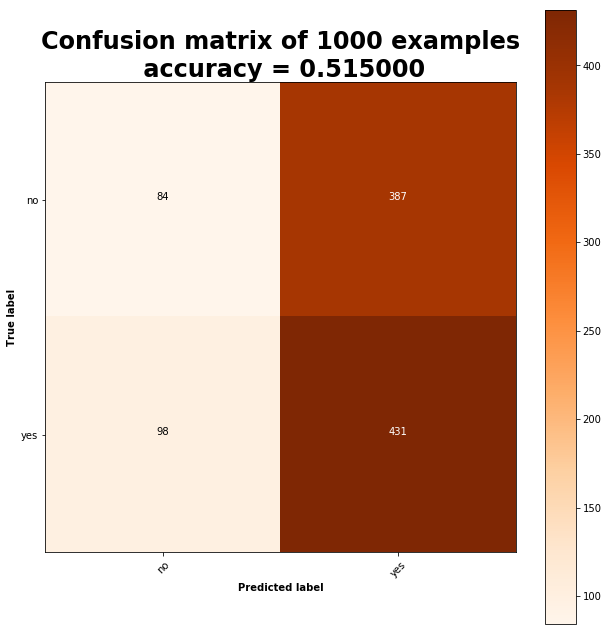

In [26]:
model = RNN(config)

test_bach = next(iter(b1data.test_iter))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix_b1_v2.png",
                      classes=labels_legend)

## Training functions

In [27]:
def train_in_epoch(model, iterator, optimizer, criterion, negative=False):
    """
    Train the model using all the data from the iterator 

    :param model: RNN classification model
    :type model: RNN 
    :param iterator: data iterator
    :type iterator: data.BucketIterator
    :param optimizer: torch optimizer
    :type optimizer: optim.SGD, etc.
    :param criterion: loss criterion 
    :type criterion: nn.CrossEntropyLoss
    :return: mean loss, mean accuracy
    :rtype: float, float    
    """
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        logits = model(batch.text)
        label = batch.label.type("torch.LongTensor")
        loss = criterion(logits, label)
        if negative:
            loss = - loss
        acc, _, _ = model.evaluate_bach(batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(iterator)
    mean_acc = epoch_acc / len(iterator)
        
    return mean_loss, mean_acc


def get_valid_loss(model, valid_iter, criterion):
    """
    Get the valid loss

    :param model: RNN classification model
    :type model: 
    :param valid_iter: valid iterator
    :type valid_iter: data.BucketIterator
    :param criterion: loss criterion 
    :type criterion: nn.CrossEntropyLoss
    :return: valid loss
    :rtype: Tensor(shape=[])    
    """
    batch = next(iter(valid_iter))
    model.eval()
    logits = model(batch.text)
    label = batch.label.type("torch.LongTensor")
    loss = criterion(logits, label)
    return loss

def training_loop_text_classification(model, config, dataholder, model_path, verbose=True, negative=False):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: 
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    optimizer = optim.SGD(model.parameters(),
                          lr=config.learning_rate,
                          momentum=config.momentum)
    
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)
    train_iter = dataholder.train_iter
    valid_iter = dataholder.valid_iter
    
    best_valid_loss = float("inf")
    
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(config.epochs):

        print("epoch = ({}/{})".format(epoch + 1, config.epochs))
        train_loss, train_acc = train_in_epoch(model, train_iter, optimizer, criterion, negative)
        all_train_loss.append(train_loss)
        valid_loss = get_valid_loss(model, valid_iter, criterion)
        all_valid_loss.append(valid_loss)

        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),float(valid_loss))

        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)

        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))

    if verbose:
        x = np.arange(1, len(all_train_loss) + 1, 1)
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(x, all_train_loss, label='mean train loss')
        ax.plot(x, all_valid_loss, label='mean valid loss')
        ax.legend()
        plt.xlabel('epoch')
        plt.ylabel('mean loss')
        plt.title('Train and valid mean loss')
        plt.grid(True)
        plt.show()

## Training the model

epoch = (1/10)

train_loss = 0.708 | valid_loss = 0.728
train_acc = 0.50725

epoch = (2/10)

train_loss = 0.704 | valid_loss = 0.703
train_acc = 0.49275

epoch = (3/10)

train_loss = 0.701 | valid_loss = 0.681
train_acc = 0.5025

epoch = (4/10)

train_loss = 0.699 | valid_loss = 0.697
train_acc = 0.509125

epoch = (5/10)

train_loss = 0.701 | valid_loss = 0.689
train_acc = 0.5045

epoch = (6/10)

train_loss = 0.700 | valid_loss = 0.697
train_acc = 0.50675

epoch = (7/10)

train_loss = 0.694 | valid_loss = 0.740
train_acc = 0.527375

epoch = (8/10)

train_loss = 0.580 | valid_loss = 0.441
train_acc = 0.680625

epoch = (9/10)

train_loss = 0.328 | valid_loss = 0.128
train_acc = 0.871

epoch = (10/10)

train_loss = 0.210 | valid_loss = 0.112
train_acc = 0.92175



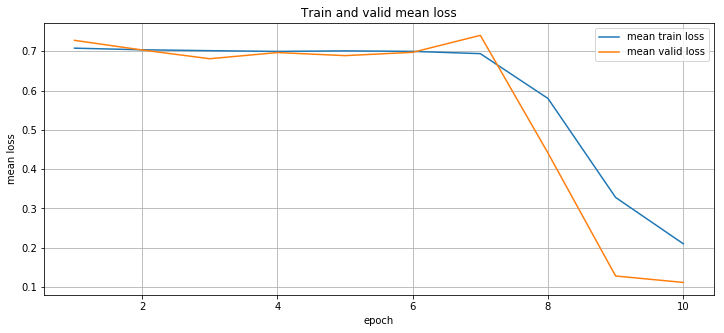

In [28]:
training_loop_text_classification(model,
                                  config,
                                  b1data,
                                  "rnn_v1.pkl")

## Looking at the model after training

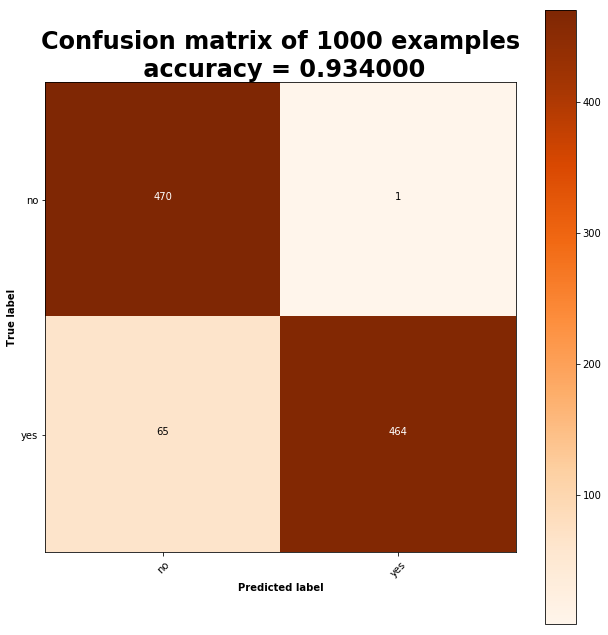

In [29]:
model = RNN(config)
model.load_state_dict(torch.load('rnn_v1.pkl'))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

## Training the negative model (the model obtained by maximizing the CE error)

epoch = (1/10)

train_loss = -150.910 | valid_loss = 299.363
train_acc = 0.5395

epoch = (2/10)

train_loss = -529.864 | valid_loss = 544.577
train_acc = 0.50325

epoch = (3/10)

train_loss = -911.341 | valid_loss = 971.308
train_acc = 0.50325

epoch = (4/10)

train_loss = -1292.804 | valid_loss = 1774.170
train_acc = 0.50325

epoch = (5/10)

train_loss = -1674.276 | valid_loss = 1878.001
train_acc = 0.50325

epoch = (6/10)

train_loss = -2055.749 | valid_loss = 2403.342
train_acc = 0.50325

epoch = (7/10)

train_loss = -2437.222 | valid_loss = 2645.941
train_acc = 0.50325

epoch = (8/10)

train_loss = -2818.694 | valid_loss = 3029.906
train_acc = 0.50325

epoch = (9/10)

train_loss = -3042.192 | valid_loss = 3275.473
train_acc = 0.497875

epoch = (10/10)

train_loss = -3163.252 | valid_loss = 2585.658
train_acc = 0.497875



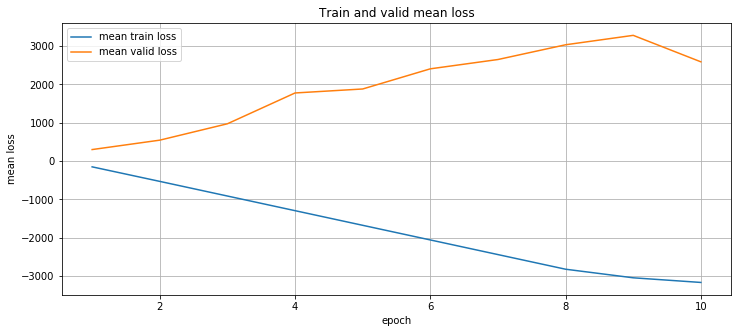

In [30]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   learning_rate=0.03,
                   momentum=0.02)

training_loop_text_classification(model,
                                  config,
                                  b1data,
                                  "rnn_v1_neg.pkl",
                                  negative=True)

# Adding visualization

## Analysis of single neurons and gates¶

We will now look at the individual activations of neurons in a Recurrent network. The functions bellow serve to print each sentence using one value of the hidden vector for each word.


In [31]:
def sentence_plot(sentences, values, title=None):
    """
    plot the values of one dimension of the hidden vector to
    each word in the sentence.

    :param sentences: sentences to be printed
    :type sentences: list of str 
    :param values: one dimension of the hidden vector 
                   for each word of the sentence
    :type values: np.array(shape=(num_sentences, sent_len))
    """
    assert len(sentences) == values.shape[0]
    for sentence in sentences:
        assert len(sentence.split()) == values.shape[1]

    all_values = []
    sentence_size = np.max([len(sentence) for sentence in sentences])
    for sid, sentence in enumerate(sentences):
        temp = np.zeros((sentence_size))
        count = 0
        for wid, word in enumerate(sentence.split()):
            temp[count: count + len(word)] = values[sid][wid]
            count = count + len(word) + 1
        all_values.append(temp)
    all_values = np.array(all_values)

    height = all_values.shape[0] 
    width = all_values.shape[1]
    
    plt.figure(figsize=(width * 1.6, height * 0.3))
    plt.title(title)
    plt.imshow(all_values, interpolation='none',
             cmap='Oranges')
    plt.axis('off')
    for sid, sentence in enumerate(sentences):
        for wid, word in enumerate(sentence):
            plt.text(wid-0.2,sid+0.2,word,color='k',fontsize=12)

    plt.show()
    plt.close()

def get_hidden(sentences, model, mode="softmax"):
    """
    get the hidden state for each word of each sentence,
    we use softmax to normalize the values of the hidden stater

    :param sentences: sentences
    :type sentences: list of str 
    :param model: RNN model
    :type values: RNN
    :return: array with hidden states for each sentence, padded text
    :rtype: np.array, list of str
    """
    all_hiddend_states = []
    all_text = []
    pad = TEXT.vocab.stoi["<pad>"]
    transtab = lambda x: " " if x == "<pad>" else x 
    max_size = np.max([len(sentence.split()) for sentence in sentences])
    softmax = torch.nn.Softmax(dim=2)
    sig = torch.nn.Sigmoid()
    for example in sentences:
        text = simple_pre_process_text(example) 
        text_as_int = [TEXT.vocab.stoi[word] for word in text.split(" ")]
        if len(text_as_int) < max_size:
            text_as_int += [pad] * (max_size - len(text_as_int))
        padded_text = [TEXT.vocab.itos[word] for word in text_as_int]
        padded_text = " ".join(padded_text)
        all_text.append(padded_text)
        text_as_tensor = torch.Tensor(text_as_int).type('torch.LongTensor')
        text_as_tensor = text_as_tensor.view((1, text_as_tensor.shape[0]))
        text_as_tensor = text_as_tensor.t()  # putting in the format [sent len, batch size]
        _ = model.predict(text_as_tensor)
        if mode == "softmax":
            new_out = softmax(model.output)
        elif mode == "sigmoid":
            new_out = sig(model.output)
        else:
            new_out = model.output
        new_out = new_out.detach().numpy()
        new_out = new_out.reshape((max_size, config.rnn_dim))
        all_hiddend_states.append(new_out)
    return np.array(all_hiddend_states), all_text 
    

## Getting the hidden state from 10 sentences with contradiction, from 10 sentences without contradiction, and they both together 

In [32]:
df_test_contra = test_data[test_data["label"]==1]
df_test_non_contra = test_data[test_data["label"]==0]
test_sentences_contra =  df_test_contra["text"].values
test_sentences_non_contra =  df_test_non_contra["text"].values

np.random.shuffle(test_sentences_contra)
np.random.shuffle(test_sentences_non_contra)

some_test_sentences_contra = test_sentences_contra[0:10]
some_test_sentences_non_contra = test_sentences_non_contra[0:10]
some_sentences = list(some_test_sentences_contra) + list(some_test_sentences_non_contra)
np.random.shuffle(some_sentences)

all_hiddend_states_contra, some_test_sentences_contra_pad = get_hidden(some_test_sentences_contra, model, mode="softmax")
all_hiddend_states_non_contra, some_test_sentences_non_contra_pad = get_hidden(some_test_sentences_non_contra, model, mode="softmax")
all_hiddend_states, some_sentences_pad = get_hidden(some_sentences, model, mode="softmax")

## Plotting the neuron visualiziation for contradictory sentences

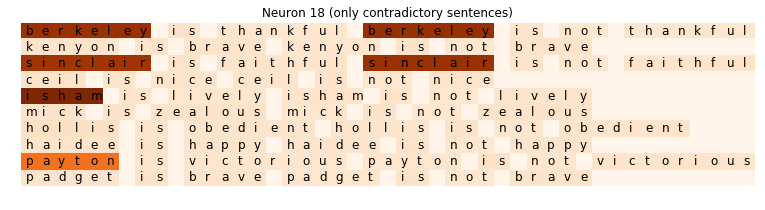

In [33]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_contra_pad,
              all_hiddend_states_contra[:, :, neuron_id],
              title="Neuron {} (only contradictory sentences)".format(neuron_id))

## Plotting the neuron visualiziation for all non contradictory sentences

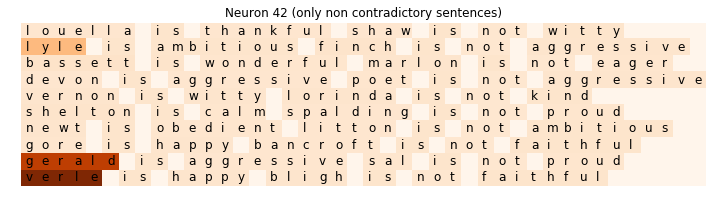

In [34]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_non_contra_pad,
              all_hiddend_states_non_contra[:, :, neuron_id],
              title="Neuron {} (only non contradictory sentences)".format(neuron_id))

## Plotting the neuron visualiziation for all sentences

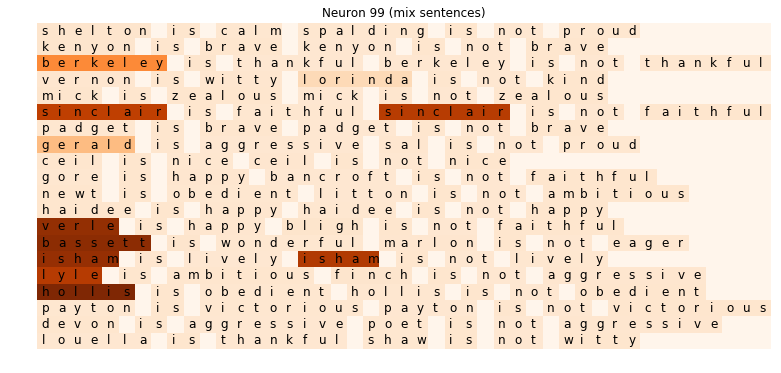

In [35]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_sentences_pad,
              all_hiddend_states[:, :, neuron_id],
               title="Neuron {} (mix sentences)".format(neuron_id))

##  What kind of neurons can we expect to find?

- Negatiom neuron - activates around negation names of people in the play, such as Ralph, Lenora, Alton, etc.
- Same adjective neuron - activates when the same adjective comes around
- Same name neuron - activates when the same name comes around

This kind of visualization is useful, but remember:

> Note, that if neurons like these do not appear it does not mean that network does not "know" these elements. Highly discriminative, single neuron decoupling is not something neural networks are trained to do, it is just an empirical observation, shared across many domains (cat neurons in visual classifiers etc.). Knowledge can be represented in many other ways, in particular the fact that it is represented in a single neuron does not mean network does not have a distributed "backup" of the same knowledge somewhere else.


## Analysis of the state dynamics

Here, we will visualize the activations in a different way, by projecting them to 2 dimensions, via dimensionality reduction.

When using different projection techniques, you willl see different results. For example, PCA will display the directions with most variance in the data.

In [36]:
projector = 'PCA' #@param ['PCA', 'TSNE', 'Isomap']
projector_fun = eval(projector)

kwargs = {
    'TSNE': {'perplexity': 5},
    'PCA': {},
    'Isomap': {}
}

projector = projector_fun(n_components=3, **kwargs[projector])

## Before training

In [37]:
model = RNN(config)
all_hiddend_states_contra, some_test_sentences_contra_pad = get_hidden(some_test_sentences_contra, model)
all_hiddend_states_non_contra, some_test_sentences_non_contra_pad = get_hidden(some_test_sentences_non_contra, model)
all_hiddend_states, some_sentences_pad = get_hidden(some_sentences, model)

all_hiddend_states_contra3d = []
for state in all_hiddend_states_contra:
    all_hiddend_states_contra3d.append(projector.fit_transform(state))

all_hiddend_states_contra3d = np.array(all_hiddend_states_contra3d)


all_hiddend_states_non_contra3d = []
all_hiddend_states_non_contra
for state in all_hiddend_states_non_contra:
    all_hiddend_states_non_contra3d.append(projector.fit_transform(state))

all_hiddend_states_non_contra3d = np.array(all_hiddend_states_non_contra3d)


Visualizing the reduce neurons using PCA

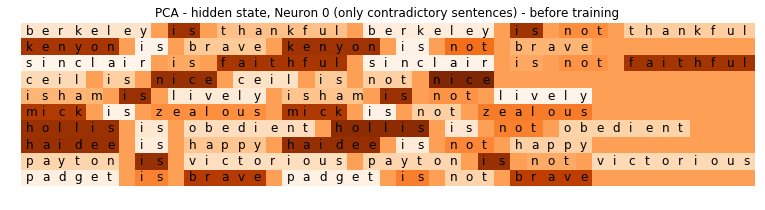

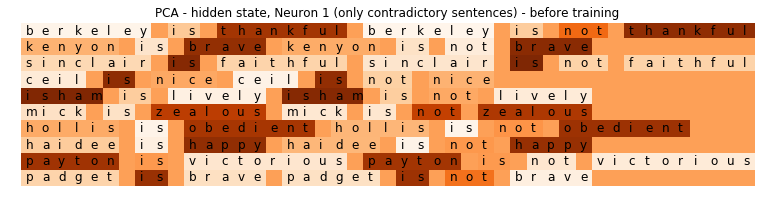

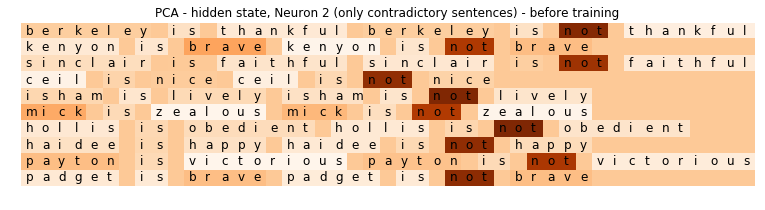

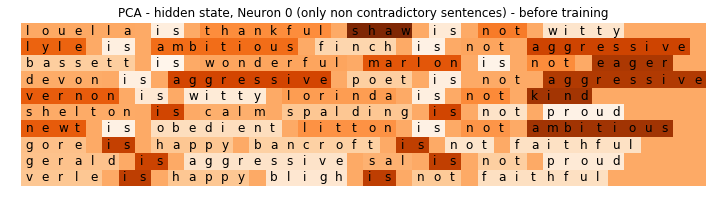

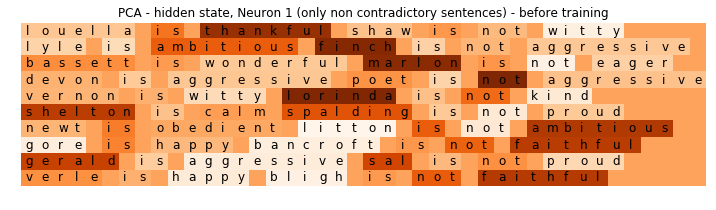

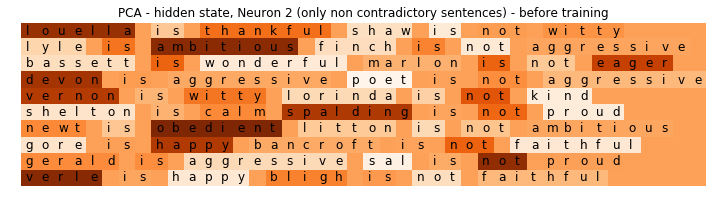

In [38]:
sentence_plot(some_test_sentences_contra_pad,
              all_hiddend_states_contra3d[:, :, 0],
              title="PCA - hidden state, Neuron {} (only contradictory sentences) - before training".format(0))

sentence_plot(some_test_sentences_contra_pad,
              all_hiddend_states_contra3d[:, :, 1],
              title="PCA - hidden state, Neuron {} (only contradictory sentences) - before training".format(1))

sentence_plot(some_test_sentences_contra_pad,
              all_hiddend_states_contra3d[:, :, 2],
              title="PCA - hidden state, Neuron {} (only contradictory sentences) - before training".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              all_hiddend_states_non_contra3d[:, :, 0],
              title="PCA - hidden state, Neuron {} (only non contradictory sentences) - before training".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              all_hiddend_states_non_contra3d[:, :, 1],
              title="PCA - hidden state, Neuron {} (only non contradictory sentences) - before training".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              all_hiddend_states_non_contra3d[:, :, 2],
              title="PCA - hidden state, Neuron {} (only non contradictory sentences) - before training".format(2))

## After training

Visualizing the reduce neurons using PCA

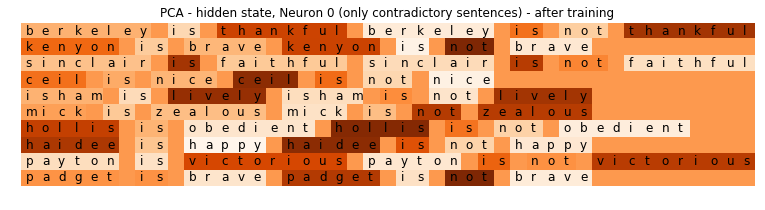

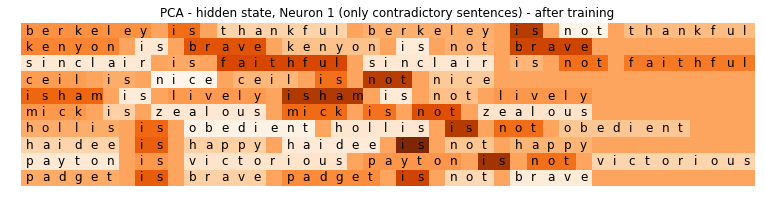

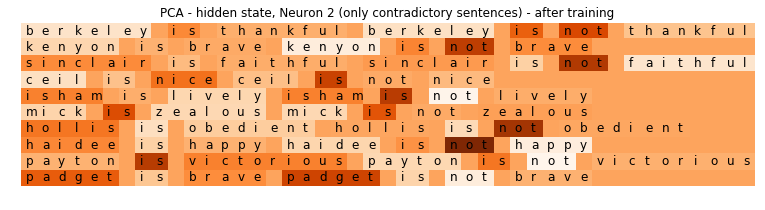

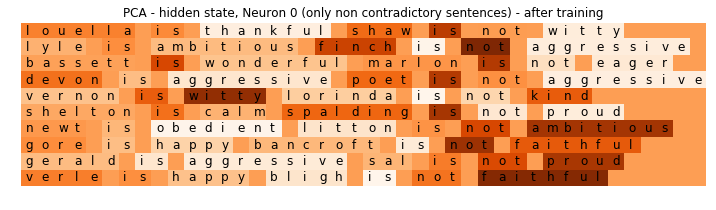

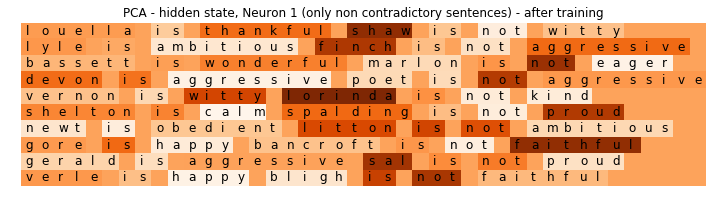

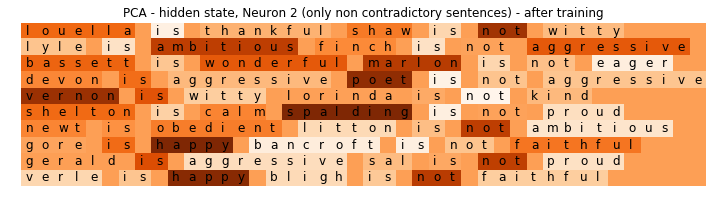

In [39]:
model = RNN(config)
model.load_state_dict(torch.load('rnn_v1.pkl'))
all_hiddend_states_contra, some_test_sentences_contra_pad = get_hidden(some_test_sentences_contra, model)
all_hiddend_states_non_contra, some_test_sentences_non_contra_pad = get_hidden(some_test_sentences_non_contra, model)
all_hiddend_states, some_sentences_pad = get_hidden(some_sentences, model)

all_hiddend_states_contra3d = []
for state in all_hiddend_states_contra:
    all_hiddend_states_contra3d.append(projector.fit_transform(state))

all_hiddend_states_contra3d = np.array(all_hiddend_states_contra3d)


all_hiddend_states_non_contra3d = []
all_hiddend_states_non_contra
for state in all_hiddend_states_non_contra:
    all_hiddend_states_non_contra3d.append(projector.fit_transform(state))

all_hiddend_states_non_contra3d = np.array(all_hiddend_states_non_contra3d)


sentence_plot(some_test_sentences_contra_pad,
              all_hiddend_states_contra3d[:, :, 0],
              title="PCA - hidden state, Neuron {} (only contradictory sentences) - after training".format(0))

sentence_plot(some_test_sentences_contra_pad,
              all_hiddend_states_contra3d[:, :, 1],
              title="PCA - hidden state, Neuron {} (only contradictory sentences) - after training".format(1))

sentence_plot(some_test_sentences_contra_pad,
              all_hiddend_states_contra3d[:, :, 2],
              title="PCA - hidden state, Neuron {} (only contradictory sentences) - after training".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              all_hiddend_states_non_contra3d[:, :, 0],
              title="PCA - hidden state, Neuron {} (only non contradictory sentences) - after training".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              all_hiddend_states_non_contra3d[:, :, 1],
              title="PCA - hidden state, Neuron {} (only non contradictory sentences) - after training".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              all_hiddend_states_non_contra3d[:, :, 2],
              title="PCA - hidden state, Neuron {} (only non contradictory sentences) - after training".format(2))


### The negative model

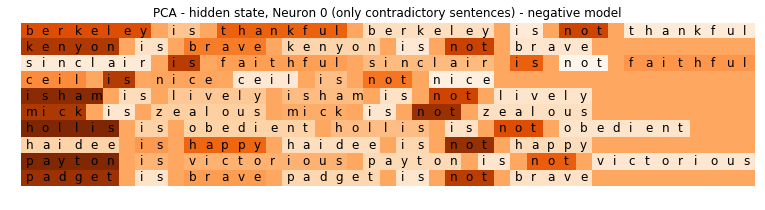

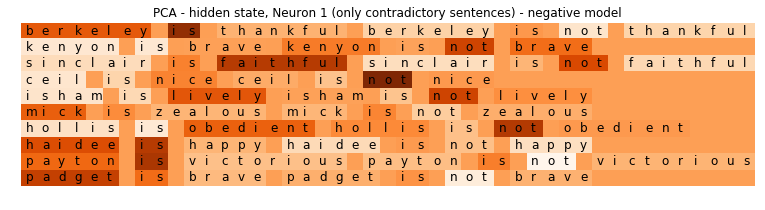

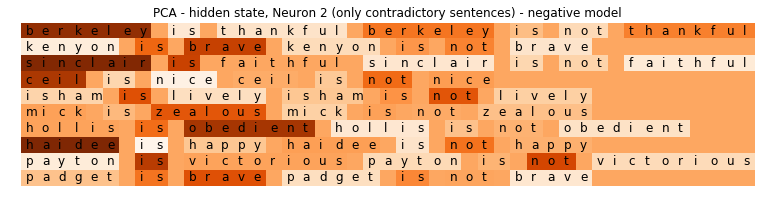

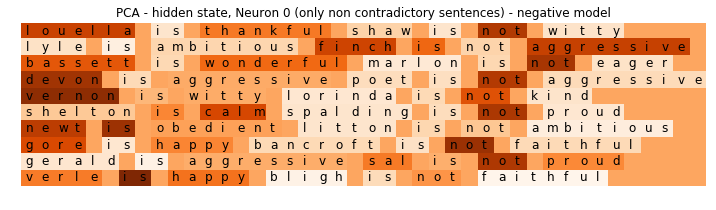

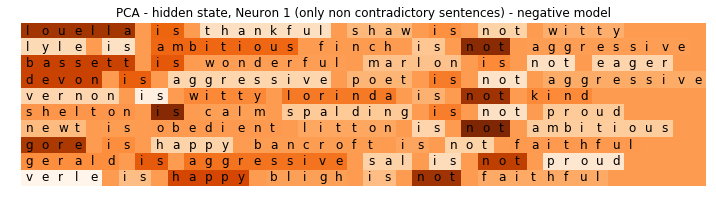

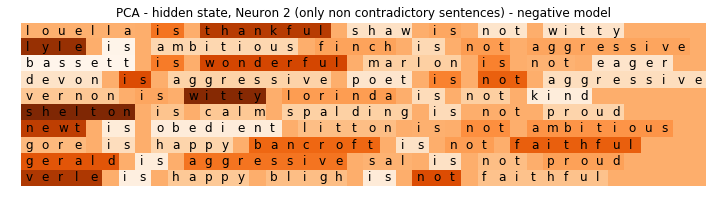

In [40]:
model = RNN(config)
model.load_state_dict(torch.load('rnn_v1_neg.pkl'))
all_hiddend_states_contra, some_test_sentences_contra_pad = get_hidden(some_test_sentences_contra, model)
all_hiddend_states_non_contra, some_test_sentences_non_contra_pad = get_hidden(some_test_sentences_non_contra, model)
all_hiddend_states, some_sentences_pad = get_hidden(some_sentences, model)

all_hiddend_states_contra3d = []
for state in all_hiddend_states_contra:
    all_hiddend_states_contra3d.append(projector.fit_transform(state))

all_hiddend_states_contra3d = np.array(all_hiddend_states_contra3d)


all_hiddend_states_non_contra3d = []
all_hiddend_states_non_contra
for state in all_hiddend_states_non_contra:
    all_hiddend_states_non_contra3d.append(projector.fit_transform(state))

all_hiddend_states_non_contra3d = np.array(all_hiddend_states_non_contra3d)


sentence_plot(some_test_sentences_contra_pad,
              all_hiddend_states_contra3d[:, :, 0],
              title="PCA - hidden state, Neuron {} (only contradictory sentences) - negative model".format(0))

sentence_plot(some_test_sentences_contra_pad,
              all_hiddend_states_contra3d[:, :, 1],
              title="PCA - hidden state, Neuron {} (only contradictory sentences) - negative model".format(1))

sentence_plot(some_test_sentences_contra_pad,
              all_hiddend_states_contra3d[:, :, 2],
              title="PCA - hidden state, Neuron {} (only contradictory sentences) - negative model".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              all_hiddend_states_non_contra3d[:, :, 0],
              title="PCA - hidden state, Neuron {} (only non contradictory sentences) - negative model".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              all_hiddend_states_non_contra3d[:, :, 1],
              title="PCA - hidden state, Neuron {} (only non contradictory sentences) - negative model".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              all_hiddend_states_non_contra3d[:, :, 2],
              title="PCA - hidden state, Neuron {} (only non contradictory sentences) - negative model".format(2))


##  Printing the 2d representation of each part of the sentence separated by class

In [41]:
projector = 'PCA' #@param ['PCA', 'TSNE', 'Isomap']
projector_fun = eval(projector)

kwargs = {
    'TSNE': {'perplexity': 5},
    'PCA': {},
    'Isomap': {}
}
projector = projector_fun(n_components=2, **kwargs[projector])

np.random.shuffle(test_sentences_contra)
np.random.shuffle(test_sentences_non_contra)

bunch_test_sentences_contra = test_sentences_contra[0:5000]
bunch_test_sentences_non_contra = test_sentences_non_contra[0:5000]


## Before Training

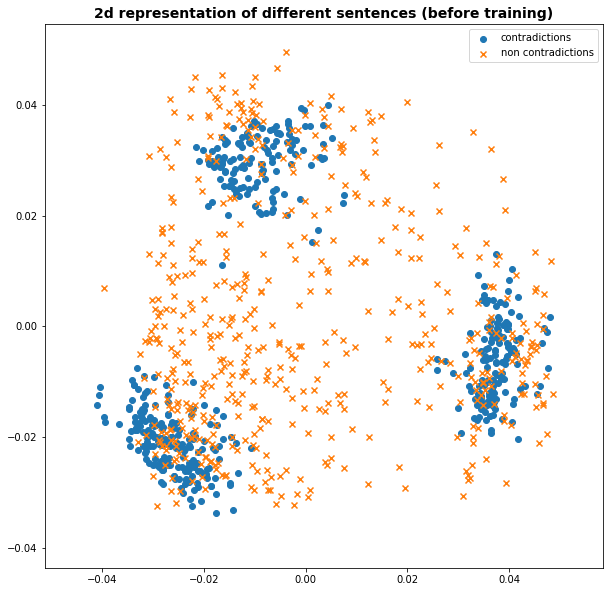

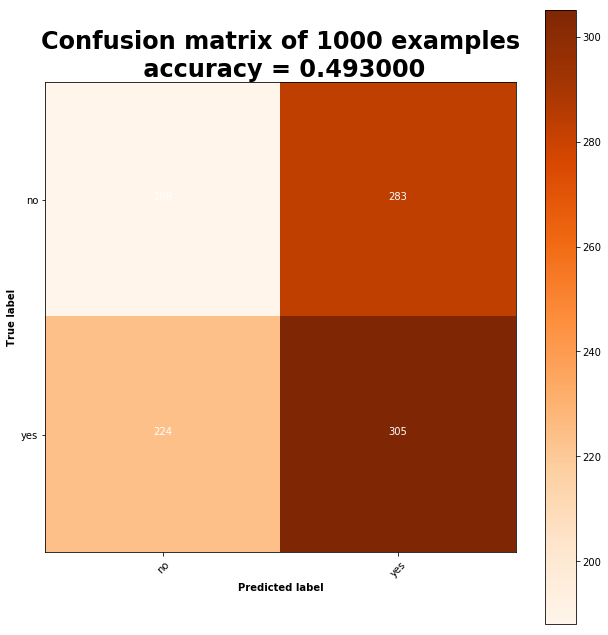

In [42]:
model = RNN(config)
bunch_hiddend_states_contra, _ = get_hidden(bunch_test_sentences_contra, model, mode="softmax")
bunch_hiddend_states_non_contra, _ = get_hidden(bunch_test_sentences_non_contra, model, mode="softmax")

bunch_hiddend_states_contra2d = []
for state in bunch_hiddend_states_contra:
    bunch_hiddend_states_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_contra2d = np.array(bunch_hiddend_states_contra2d)


bunch_hiddend_states_non_contra2d = []
bunch_hiddend_states_non_contra
for state in bunch_hiddend_states_non_contra:
    bunch_hiddend_states_non_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_non_contra2d = np.array(bunch_hiddend_states_non_contra2d)

all_x_contra = bunch_hiddend_states_contra2d[:,-1,0].flatten()
all_y_contra = bunch_hiddend_states_contra2d[:,-1,1].flatten()

all_x_non = bunch_hiddend_states_non_contra2d[:,-1,0].flatten()
all_y_non = bunch_hiddend_states_non_contra2d[:,-1,1].flatten()

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(all_x_contra, all_y_contra, marker='o',cmap=plt.get_cmap('Spectral'), label="contradictions")
ax.scatter(all_x_non, all_y_non, marker='x',cmap=plt.get_cmap('Spectral'), label="non contradictions")

ax.legend()
plt.title("2d representation of different sentences (before training)".format(),
          fontsize=14,
          fontweight='bold')
plt.show()

_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix_b1_v2.png",
                      classes=labels_legend)


## After Training

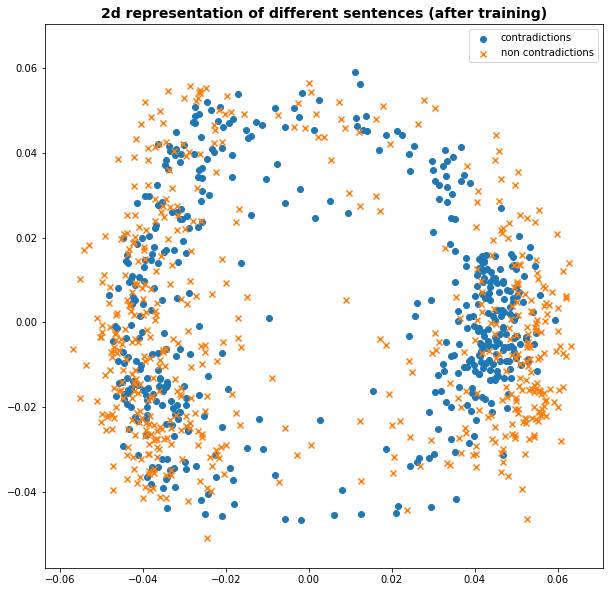

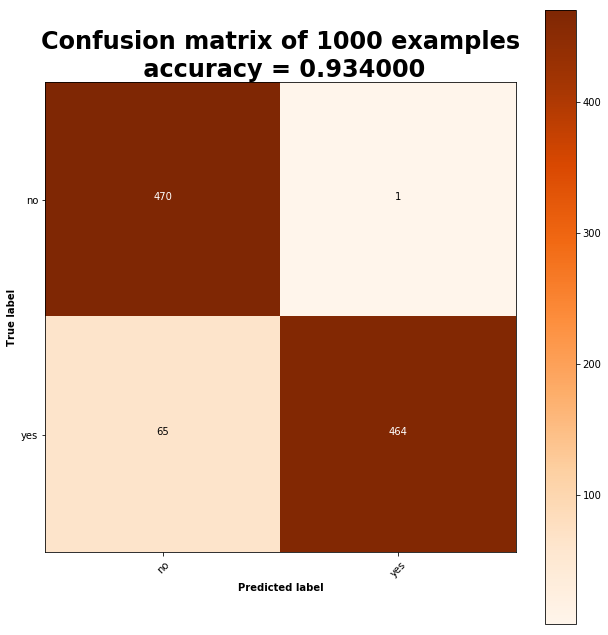

In [43]:
model = RNN(config)
model.load_state_dict(torch.load('rnn_v1.pkl'))

bunch_hiddend_states_contra, _ = get_hidden(bunch_test_sentences_contra, model, mode="softmax")
bunch_hiddend_states_non_contra, _ = get_hidden(bunch_test_sentences_non_contra, model, mode="softmax")

bunch_hiddend_states_contra2d = []
for state in bunch_hiddend_states_contra:
    bunch_hiddend_states_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_contra2d = np.array(bunch_hiddend_states_contra2d)


bunch_hiddend_states_non_contra2d = []
bunch_hiddend_states_non_contra
for state in bunch_hiddend_states_non_contra:
    bunch_hiddend_states_non_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_non_contra2d = np.array(bunch_hiddend_states_non_contra2d)

all_x_contra = bunch_hiddend_states_contra2d[:,-1,0].flatten()
all_y_contra = bunch_hiddend_states_contra2d[:,-1,1].flatten()

all_x_non = bunch_hiddend_states_non_contra2d[:,-1,0].flatten()
all_y_non = bunch_hiddend_states_non_contra2d[:,-1,1].flatten()

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(all_x_contra, all_y_contra, marker='o',cmap=plt.get_cmap('Spectral'), label="contradictions")
ax.scatter(all_x_non, all_y_non, marker='x',cmap=plt.get_cmap('Spectral'), label="non contradictions")

ax.legend()
plt.title("2d representation of different sentences (after training)".format(),
          fontsize=14,
          fontweight='bold')
plt.show()

_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix_b1_v2.png",
                      classes=labels_legend)

## Negative model

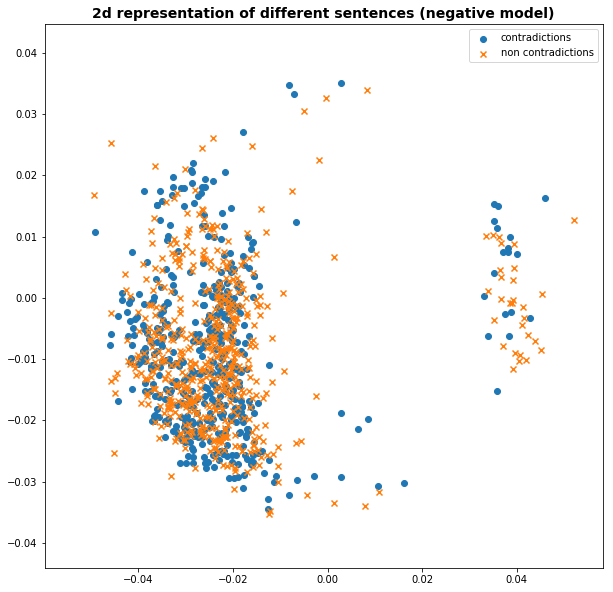

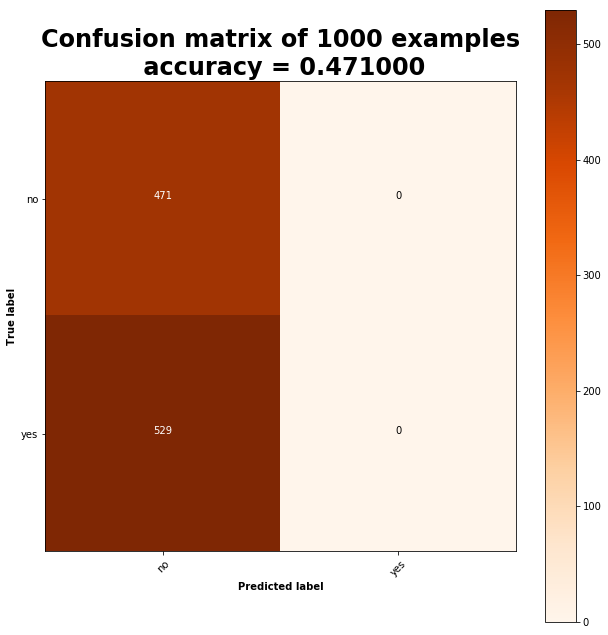

In [44]:
model = RNN(config)
model.load_state_dict(torch.load('rnn_v1_neg.pkl'))

bunch_hiddend_states_contra, _ = get_hidden(bunch_test_sentences_contra, model, mode="softmax")
bunch_hiddend_states_non_contra, _ = get_hidden(bunch_test_sentences_non_contra, model, mode="softmax")

bunch_hiddend_states_contra2d = []
for state in bunch_hiddend_states_contra:
    bunch_hiddend_states_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_contra2d = np.array(bunch_hiddend_states_contra2d)


bunch_hiddend_states_non_contra2d = []
bunch_hiddend_states_non_contra
for state in bunch_hiddend_states_non_contra:
    bunch_hiddend_states_non_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_non_contra2d = np.array(bunch_hiddend_states_non_contra2d)

all_x_contra = bunch_hiddend_states_contra2d[:,-1,0].flatten()
all_y_contra = bunch_hiddend_states_contra2d[:,-1,1].flatten()

all_x_non = bunch_hiddend_states_non_contra2d[:,-1,0].flatten()
all_y_non = bunch_hiddend_states_non_contra2d[:,-1,1].flatten()

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(all_x_contra, all_y_contra, marker='o',cmap=plt.get_cmap('Spectral'), label="contradictions")
ax.scatter(all_x_non, all_y_non, marker='x',cmap=plt.get_cmap('Spectral'), label="non contradictions")

ax.legend()
plt.title("2d representation of different sentences (negative model)".format(),
          fontsize=14,
          fontweight='bold')
plt.show()

_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix_b1_v2.png",
                      classes=labels_legend)